In [2]:
from Data_Preprocessing import exp_var, indexed_df, hate_crime

import pandas as pd
import numpy as np
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import itertools
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [3]:
exp_var

['hate_crime',
 'hate_crime_combined',
 'hc_by_year',
 'region_grouped',
 'race_grouped',
 'indexed_df']

In [4]:
indexed_df.head()

,TOTAL_INCIDENTS
INCIDENT_MONTH,
1991-01-31,302
1991-02-28,287
1991-03-31,287
1991-04-30,309
1991-05-31,371


In [5]:
indexed_df_complete = indexed_df.copy()

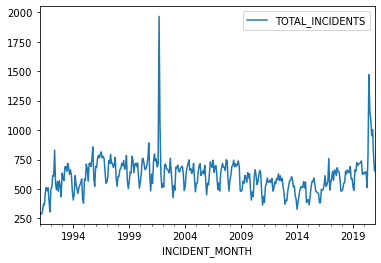

,TOTAL_INCIDENTS
INCIDENT_MONTH,
2001-09-30,1966
2001-10-31,1048
2020-06-30,1470
2020-07-31,1155
2020-08-31,1085
2020-10-31,1004


In [6]:
indexed_df.plot()
plt.show()

indexed_df[indexed_df['TOTAL_INCIDENTS'] > 1000]

### Remove outliers, months with incidents > 1000

In [7]:
replace_dict={1966:(indexed_df.loc['2000-09-30']['TOTAL_INCIDENTS'] + indexed_df.loc['2002-09-30']['TOTAL_INCIDENTS'])/2, 
              1048:(indexed_df.loc['2000-10-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2002-10-31']['TOTAL_INCIDENTS'])/2, 
              1470:(indexed_df.loc['2019-06-30']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-05-31']['TOTAL_INCIDENTS'])/2, 
              1155:(indexed_df.loc['2019-07-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-05-31']['TOTAL_INCIDENTS'])/2, 
              1085:(indexed_df.loc['2019-08-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-05-31']['TOTAL_INCIDENTS'])/2, 
              1004:(indexed_df.loc['2019-10-31']['TOTAL_INCIDENTS'] + indexed_df.loc['2020-09-30']['TOTAL_INCIDENTS'])/2 
             }

print(replace_dict)

indexed_df.replace(to_replace=replace_dict, inplace=True)

{1966: 762.0, 1048: 772.0, 1470: 736.0, 1155: 742.5, 1085: 745.0, 1004: 845.0}


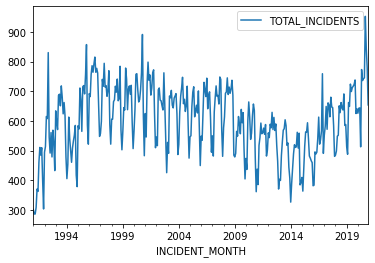

In [8]:
indexed_df.plot()
plt.show()

### Seasonality and stationarity

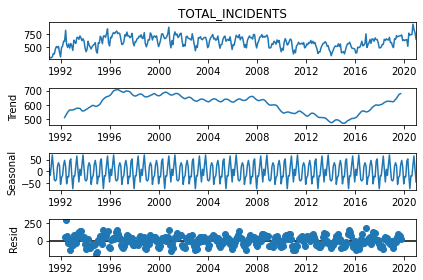

In [9]:
decompose_data = seasonal_decompose(indexed_df['TOTAL_INCIDENTS'], period=30)

decompose_plot = decompose_data.plot()

## trend is not consistent
##variation in residuals mostly accounted for in 2001 spike

<AxesSubplot:xlabel='INCIDENT_MONTH'>

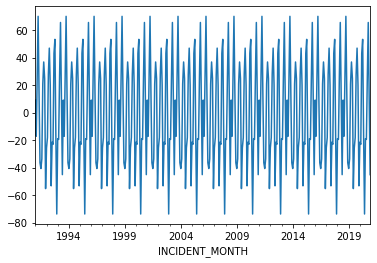

In [10]:
#inspect seasonality
seasonality = decompose_data.seasonal
seasonality.plot()

In [11]:
#Augmented Dickey Fuller test

dftest = adfuller(indexed_df.TOTAL_INCIDENTS, autolag = 'AIC')
print("ADF: ",dftest[0])
print("P-Value: ", dftest[1])
print("Num Of Lags: ", dftest[2])
print("Num Of Observations:", dftest[3])
print("Critical Values:")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
    
## p-value is high, well above threshold of 0.05
##dataset is non-stationary

ADF:  -2.3563481920398264
P-Value:  0.15443758406898878
Num Of Lags:  14
Num Of Observations: 345
Critical Values:
	 1% :  -3.4494474563375737
	 5% :  -2.8699542285903887
	 10% :  -2.5712527305187987


<AxesSubplot:title={'center':'original'}, xlabel='INCIDENT_MONTH'>

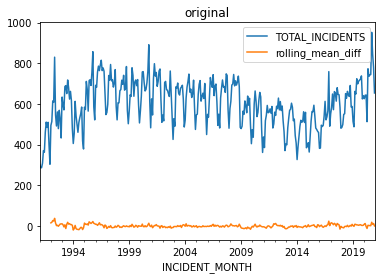

In [12]:
## use rolling mean as differencing method to impose stationarity

rolling_mean = indexed_df['TOTAL_INCIDENTS'].rolling(window = 12).mean()
indexed_df['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()

#plot original df and rolling mean difference together
indexed_df[['TOTAL_INCIDENTS', 'rolling_mean_diff']].plot(title='original')

In [13]:
#perform Augmented Dickey Fuller Test again on rolling_mean_diff

dftest = adfuller(indexed_df['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("ADF: ",dftest[0])
print("P-Value: ", dftest[1])
print("Num Of Lags: ", dftest[2])
print("Num Of Observations:", dftest[3])
print("Critical Values:")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
    
## p value is much lower than 0.05 now; stationarity has been corrected with d=1

ADF:  -4.174192567360622
P-Value:  0.0007284062649401091
Num Of Lags:  14
Num Of Observations: 333
Critical Values:
	 1% :  -3.450141065277327
	 5% :  -2.870258846235788
	 10% :  -2.571415151457764


### ACF and PACF

In [14]:
indexed_df

,TOTAL_INCIDENTS,rolling_mean_diff
INCIDENT_MONTH,,
1991-01-31,302.0,NaN
1991-02-28,287.0,NaN
1991-03-31,287.0,NaN
1991-04-30,309.0,NaN
1991-05-31,371.0,NaN
...,...,...
2020-08-31,745.0,2.333333
2020-09-30,952.0,19.083333
2020-10-31,845.0,8.916667


In [15]:
#confidence interval
ci = 1.96/np.sqrt(len(indexed_df))
ci

# look into this, sigma?

0.10330107023216706

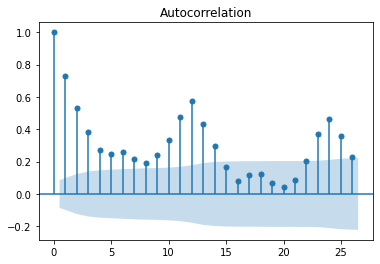

In [16]:
#ACF  (q value)
acf_array = acf(indexed_df['TOTAL_INCIDENTS'], fft=False)
plot_acf(indexed_df['TOTAL_INCIDENTS'], lags=26, alpha=ci)
plt.show()

#q=6

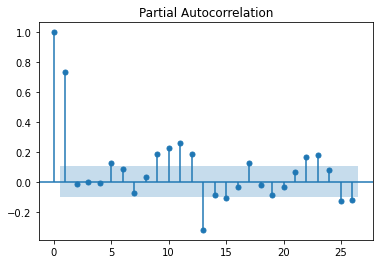

In [17]:
#PACF (p value)
plot_pacf(indexed_df['TOTAL_INCIDENTS'], lags = 26)
plt.show()

#p=3/4

In [18]:
## drop null values created by differencing

indexed_df.isnull().sum()
indexed_df.dropna(axis=1, inplace=True)

In [19]:
#ensure frequency is set for timeseries models
indexed_df = indexed_df.asfreq('M')

## SARIMAX

In [20]:
#p = lags in the autoregresive model
p = 0
#d = differencing / integration order
d = 1
#q = moving average lags
q = 2

my_order=(p,d,q)

#Seasonal order
P = 0
D = 2
Q = 2
m = 12

my_seasonal_order = (P,D,Q,m)

# best model from gridsearch
# (0, 1, 2) x (0, 2, 2, 12)

In [78]:
def sarimax_func(df, y_col, input_order, input_seasonal_order, pred_start, pred_end, title):
    model = SARIMAX(df[y_col], order=input_order, seasonal_order=input_seasonal_order)
    results = model.fit()
    print(results.summary())
   
    
    #prediction
    df['prediction']=results.predict(start=pred_start,end=pred_end,dynamic=True)
    
    #plotting
    plt.figure(figsize=(12,8))
    plt.grid(axis='y')
    plt.xlabel('DATE')
    plt.ylabel(y_col)
    plt.title(str(input_order) +(' x ')+ str(input_seasonal_order) + ' SARIMAX of ' + str(title))
    actual, = plt.plot(df[y_col], label='Observed')
    prediction, = plt.plot(df['prediction'], label='Prediction')
    legend = plt.legend(loc='lower right', fontsize='large')
    plt.show()
    
    # Forecast 1y
    years = 1
    pred_uc = results.get_forecast(steps=12*years)
    pred_ci = pred_uc.conf_int()
    ax = df[y_col].plot(label='Observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y_col)
    plt.title(str(input_order) +(' x ')+ str(input_seasonal_order) + ' SARIMAX 1 Year Prediction of ' + str(title))
    plt.legend(loc='lower right', fontsize='large')
    plt.show()


    # Forecast 5y
    years = 5
    pred_uc = results.get_forecast(steps=12*years)
    pred_ci = pred_uc.conf_int()
    ax = df[y_col].plot(label='Observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('y_col')
    plt.title(str(input_order) +(' x ')+ str(input_seasonal_order) + ' SARIMAX 5 Year Prediction of ' + str(title))
    plt.legend(loc='lower right', fontsize='large')
    plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                    TOTAL_INCIDENTS   No. Observations:                  360
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 12)   Log Likelihood               -1872.884
Date:                            Mon, 07 Mar 2022   AIC                           3755.769
Time:                                    23:13:11   BIC                           3774.839
Sample:                                01-31-1991   HQIC                          3763.372
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4898      0.047    -10.393      0.000      -0.582      -0.397
ma.L2         -0.1311      0.047   

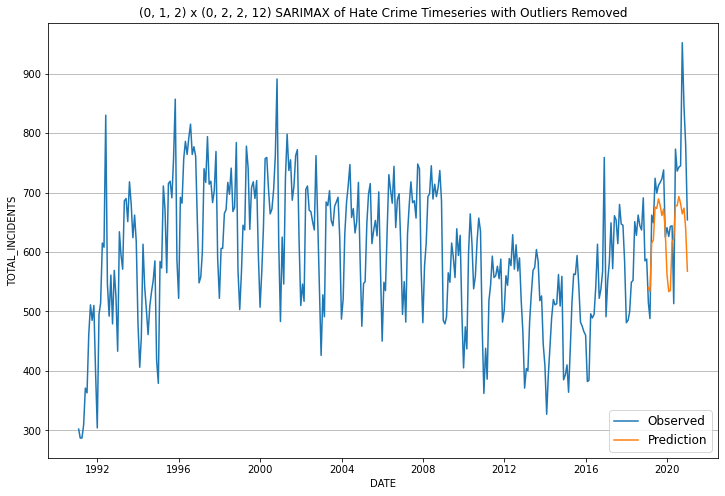

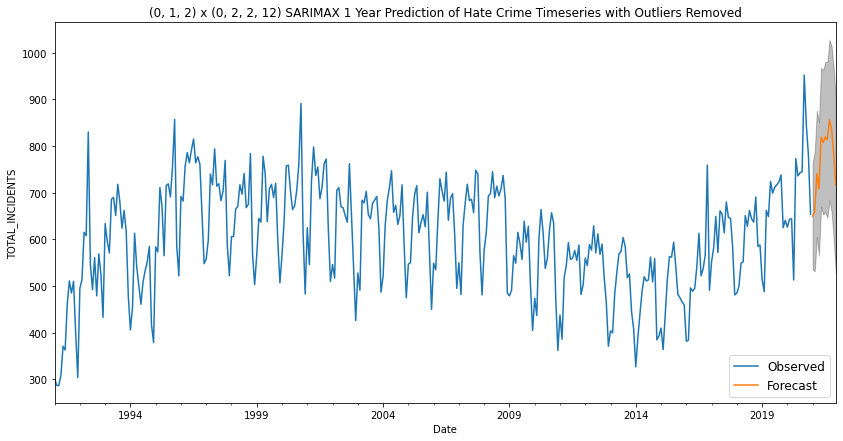

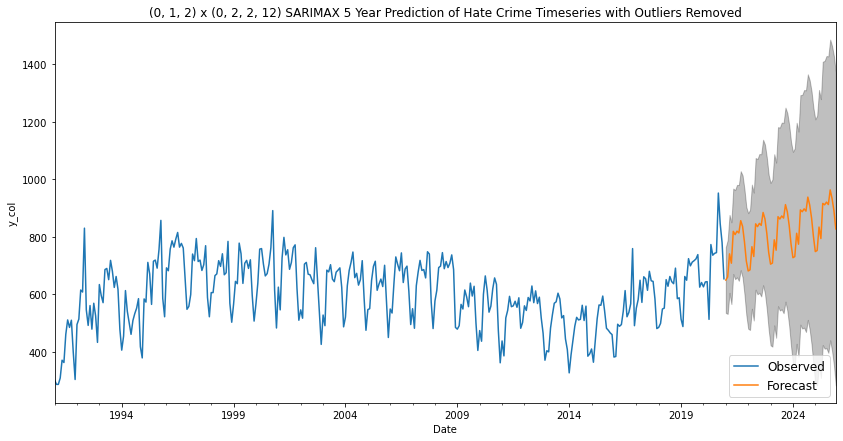

In [79]:
sarimax_func(indexed_df, 'TOTAL_INCIDENTS', my_order, my_seasonal_order, 
             '2019-01', '2020-12', 'Hate Crime Timeseries with Outliers Removed')

                                     SARIMAX Results                                      
Dep. Variable:                    TOTAL_INCIDENTS   No. Observations:                  360
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 12)   Log Likelihood               -2070.592
Date:                            Mon, 07 Mar 2022   AIC                           4151.183
Time:                                    23:13:21   BIC                           4170.254
Sample:                                01-31-1991   HQIC                          4158.786
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5300      0.029    -18.487      0.000      -0.586      -0.474
ma.L2         -0.2409      0.051   

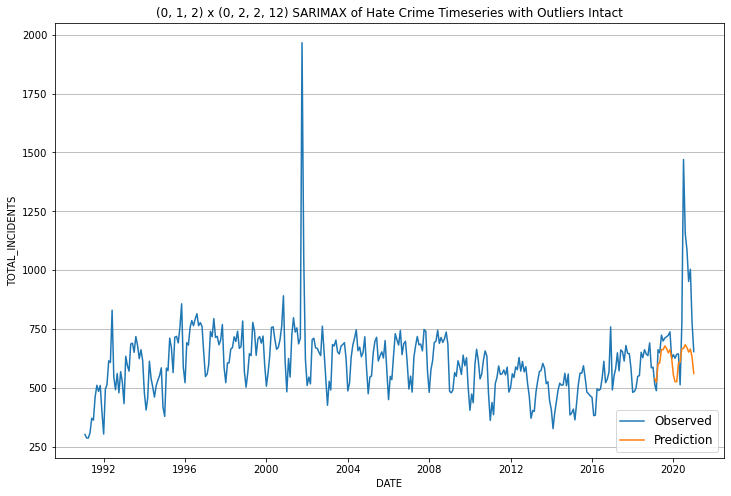

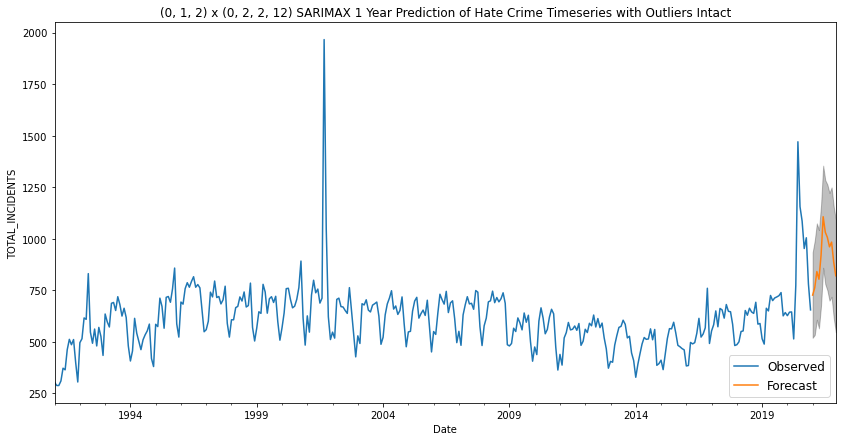

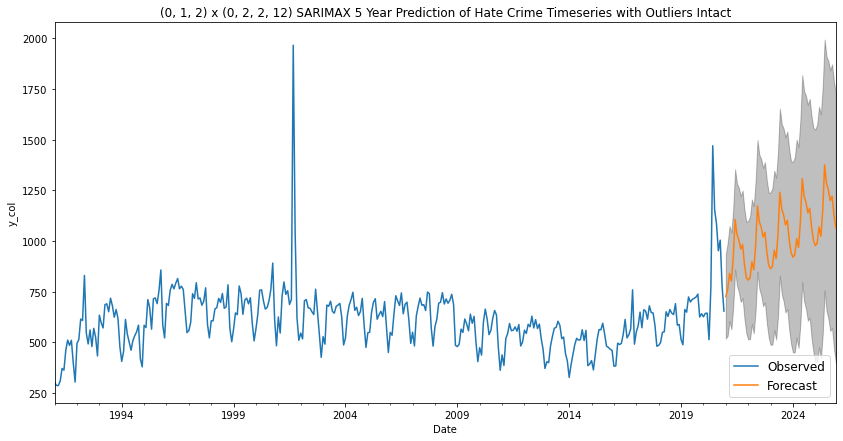

In [80]:
sarimax_func(indexed_df_complete, 'TOTAL_INCIDENTS', my_order, my_seasonal_order, 
             '2019-01', '2020-12', 'Hate Crime Timeseries with Outliers Intact')

#### Parameter Tuning

In [25]:
p = d = q = range(0, 3)

In [26]:
pdq = list(itertools.product(p, d, q))

In [27]:
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [28]:
ts = indexed_df[['TOTAL_INCIDENTS']]

In [29]:
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df

In [30]:
#results_df = sarimax_gridsearch(ts, pdq, pdqs, freq='M')
#results_df

In [31]:
# SARIMAX (0, 1, 2) x (0, 2, 2, 12)12 : BIC Calculated =3391.062465988071

In [32]:
#results_df[results_df['bic'].min()]